# BERTopic for Restaurant Review

In [ ]:
# !pip install -U bertopic
# !pip install git+https://github.com/MaartenGr/BERTopic.git#egg=bertopic

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP

In [ ]:
import os
import pandas as pd

## Explore and Preprocess the Data

In [ ]:
# data from Kaggle: https://www.kaggle.com/datasets/vigneshwarsofficial/reviews?resource=download
df = pd.read_csv('/Users/tdi/Documents/Teaching/DS/2023/Data/Restaurant_Reviews.tsv', sep='\t')

In [ ]:
df.sample(5)

In [ ]:
df.Liked.value_counts()

In [ ]:
df['text_len'] = df.Review.str.len()

In [ ]:
df.text_len.describe()

In [ ]:
docs = df.Review.to_list()

In [ ]:
# BERTopic’s documentation suggests not to remove the stop words before the documents are used to generate the embeddings
# Use CountVectorizer instead
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

In [91]:
%%time
# Precalculate the embeddings
# model_embedding : embedding model based on Sentence Transformer
model_embedding = SentenceTransformer('all-MiniLM-L6-v2')
# model_embedding = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# corpus_embeddings : embeddings generated from the texts
corpus_embeddings = model_embedding.encode(docs)

CPU times: user 6.47 s, sys: 638 ms, total: 7.11 s
Wall time: 6.07 s


## Train the Model

In [92]:
# instantiate and train the BERTopic model
# n_gram_range parameter = number of words, representing a topic
# nr_topics = number of topics to reduce the text to
# min_topic_size = minimum size of a topic
# seed_topic_list = kind of a prompt for searched topics

In [93]:
%%time
model = BERTopic(
    n_gram_range=(1, 2),
    vectorizer_model=vectorizer_model,
    nr_topics='auto',
    min_topic_size=10,
    # diversity=0.7,
    seed_topic_list=[
        ["experience", "bad", "good", "nice"],
        ["place", "atmosphere", "toilet", "clean"],
        ["staff", "waitress", "service"],
        ["wait", "time", "long"],
        ["food", "taste"]
    ],
    calculate_probabilities=True).fit(docs, corpus_embeddings)

CPU times: user 8.08 s, sys: 99.6 ms, total: 8.18 s
Wall time: 2.72 s


In [94]:
# generate topics and their probabilities
topics, probabilities = model.transform(docs, corpus_embeddings)

In [95]:
# visualize the topics that were generated
model.visualize_topics()

In [96]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

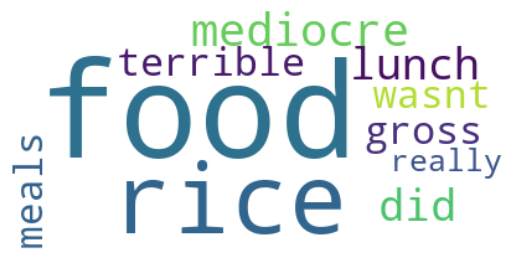

In [97]:
# Show wordcloud
create_wordcloud(model, topic=4)

In [98]:
docs

['Wow... Loved this place.',
 'Crust is not good.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.',
 'Would not go back.',
 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.',
 'I tried the Cape Cod ravoli, chicken, with cranberry...mmmm!',
 'I was disgusted because I was pretty sure that was human hair.',
 'I was shocked because no signs indicate cash only.',
 'Highly recommended.',
 'Waitress was a little slow in service.',
 'This place is not worth your time, let alone Vegas.',
 'did not like at all.

In [99]:
# topic_model_descriptions = BERTopic(language="multilingual")

The default embedding model is _all-MiniLM-L6-v2_ when selecting language="english" and _paraphrase-multilingual-MiniLM-L12-v2_ when selecting language="multilingual".

## Validation and Explanation

In [85]:
# how many topics have been found
df_topic_freq = model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
0,-1,331
1,0,167
2,1,91
3,2,62
4,3,45
5,4,45
6,5,45
7,6,40
9,7,28
8,8,28


In [86]:
# create bar charts out of the c-TF-IDF term scores for each topic representation
model.visualize_barchart(top_n_topics=topics_count)

In [130]:
# reduce the document embeddings to 2-dimensional space for easier visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)

In [131]:
# read the exact documents that are clustered under that topic 
# hover over the dots (each dot is a document)
model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

### Remove Outliers/Redistribute Clusters - not working
They are labeled as __topic -1__ Use _reduce_outliers()_ function in one of two ways:

In [102]:
# "c-tf-idf" strategy
# new_topics = model.reduce_outliers(docs, topics, strategy="c-tf-idf")

#`probabilities` strategy
new_topics = model.reduce_outliers(docs, topics, probabilities=probabilities, strategy="probabilities")


In [103]:
# extract and visualize the selected topics' representation per class: positive or negative
classes=df.Liked.to_list()
topics_in_class = model.topics_per_class(docs, classes=classes)

In [104]:
# update the topics
model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

In [105]:
# extract and visualize the selected topic's representation per class: positive or negative
# topic=None
model.visualize_topics_per_class(topics_in_class, top_n_topics=None)

In [106]:
# topic = 14
model.visualize_topics_per_class(topics_in_class, top_n_topics=10)

In [132]:
# topic -1 should be removed
model.get_topic_freq()

,Topic,Count
0,0,372
1,1,108
2,6,68
3,2,60
4,3,47
5,4,44
6,12,43
7,8,38
8,5,36
9,10,33


In [133]:
# This variable store the number of topic clusters being created
topics_count = len(df_topic_freq) - 1
topics_count

16

In [134]:
model.visualize_barchart(top_n_topics=topics_count)

In [135]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(corpus_embeddings)
model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

### Document per Topic

In [142]:
topics, probs = model.fit_transform(docs) 

In [141]:
dft = pd.DataFrame({'topic': topics, 'document': docs})
dft

,topic,document
0,0,Wow... Loved this place.
1,-1,Crust is not good.
2,4,Not tasty and the texture was just nasty.
3,-1,Stopped by during the late May bank holiday of...
4,10,The selection on the menu was great and so wer...
...,...,...
995,4,I think food should have flavor and texture an...
996,3,Appetite instantly gone.
997,6,Overall I was not impressed and would not go b...
998,18,"The whole experience was underwhelming, and I ..."


In [145]:
topic_0 = df[dft.topic == 0]
topic_0

,Review,Liked,text_len
0,Wow... Loved this place.,1,24
32,I found this place by accident and I could not...,1,58
34,"Overall, I like this place a lot.",1,33
38,My first visit to Hiro was a delight!,1,37
64,We are so glad we found this place.,1,35
...,...,...,...
921,This place is disgusting!,0,25
935,This place lacked style!!,0,25
976,"too bad cause I know it's family owned, I real...",0,75
988,It really is impressive that the place hasn't ...,0,58


### Alternative

In [151]:
T = model.get_document_info(docs)
docs_per_topics = T.groupby(["Topic"]).apply(lambda x: x.index).to_dict()
docs_per_topics

{-1: Int64Index([  1,   3,   9,  12,  13,  15,  16,  20,  21,  24,
             ...
             963, 968, 970, 971, 972, 981, 983, 984, 990, 992],
            dtype='int64', length=330),
 0: Int64Index([  0,  23,  32,  34,  38,  64,  74,  83, 115, 158, 160, 178, 200,
             230, 234, 253, 260, 288, 289, 293, 316, 324, 334, 377, 391, 396,
             423, 439, 459, 502, 505, 550, 552, 554, 556, 559, 565, 570, 611,
             614, 624, 675, 678, 707, 713, 755, 764, 787, 795, 797, 799, 803,
             814, 819, 846, 921, 935, 976, 988, 989],
            dtype='int64'),
 1: Int64Index([ 10,  22,  39,  43,  72,  76, 100, 121, 146, 147, 176, 204, 221,
             243, 249, 255, 256, 263, 266, 281, 291, 304, 320, 364, 382, 398,
             408, 419, 432, 478, 508, 573, 574, 577, 579, 679, 695, 703, 708,
             717, 729, 739, 753, 759, 763, 773, 801, 810, 811, 824, 828, 831,
             861, 868, 886, 895, 942, 950, 953, 974],
            dtype='int64'),
 2: Int64Index([ 1

### Topic per Document

In [155]:
# To visualize the topic distributions in a document
doc_id = 4
model.visualize_distribution(topic_distr[doc_id])

### Merging the Topic Clusters

In [ ]:
# manually
topics_to_merge = [[1, 4]]
model.merge_topics(docs, topics_to_merge)

In [ ]:
# how many topics have been found
df_topic_freq = model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

In [ ]:
# This variable store the number of topic clusters being created
topics_count = len(df_topic_freq) - 1
topics_count

In [ ]:
model.visualize_barchart(top_n_topics=topics_count)

### Set Labels as Relevant

In [ ]:
# manually
topic_labels_dict = {
    0: "Environment",
    1: "Service",
    2: "Food & Taste",
    3: "Overall Experience",
    4: "Food & Taste",
    5: "Waiting Time",
    6: "Fries and Potato",
    7: "Steak",
    8: "Price",
    9: "Food & Taste",
    10: "Pizza",
    11: "Staff",
    12: "Rating",
    13: "Staff",
    14: "Staff"
}
model.set_topic_labels(topic_labels_dict)

In [ ]:
df['Liked']

In [ ]:
docs = df["Review"]

In [ ]:
%%time
model = BERTopic(
    n_gram_range=(1, 2),
    vectorizer_model=vectorizer_model,
    nr_topics='auto',
    min_topic_size=10,
    diversity=0.7,
    seed_topic_list=[
        ["experience", "bad", "good", "nice"],
        ["place", "atmosphere", "toilet", "clean"],
        ["staff", "waitress", "service"],
        ["wait", "time", "long"],
        ["food", "taste"]
    ],
    calculate_probabilities=True).fit(docs, corpus_embeddings)

## Reference

https://maartengr.github.io/BERTopic/api/bertopic.html<br>
https://medium.com/@nick_tsyen/topic-modeling-with-bertopic-a-cookbook-with-an-end-to-end-example-part-1-3ef739b8d9f8<br>
https://medium.com/@nick_tsyen/topic-modeling-with-bertopic-a-cookbook-with-an-end-to-end-example-part-2-1ae591f76a25